## Setup

In [1]:
import networkx as nx
from networkx.algorithms import bipartite

import itertools
import math
import statistics
from scipy import stats as st

from time import perf_counter
# from tqdm.notebook import trange, tqdm
from tqdm import trange, tqdm

import matplotlib.pyplot as plt
from cycler import cycler

In [2]:
from numpy.random import default_rng
rng = default_rng()

In [3]:
# matplotlib default prop_cycle
cycler1 = cycler(color=[
    '#1f77b4', 
    '#ff7f0e', 
    '#2ca02c', 
    '#d62728', 
    '#9467bd', 
    '#8c564b', 
    '#e377c2', 
    '#7f7f7f', 
    '#bcbd22', 
    '#17becf'
])

# cycler2 = cycler(marker=['1', '2', '3', '4', '+', 'x', 4, 5, 6, 7])
cycler2 = cycler(linestyle=[
    'solid',
    (0, (3,1,1,1)),
    'dashed',
    'dashdot',
    'solid',
    'dotted',
    'dashed',
    'dashdot',
    'solid',
    'dotted'
])

default_cycler = cycler1 + cycler2
plt.rc('axes', prop_cycle=default_cycler)

## Utility functions

In [4]:
def draw_edge_set(G, edges):
    colors = []
    for (u,v) in G.edges:
        if (u,v) in edges or (v,u) in edges:
            colors.append("red")
        else:
            colors.append("black")

    nx.draw_networkx(G, edge_color=colors)

In [5]:
def contract(u, v, orientations):
    if orientations == (0,0):
        return tuple(reversed(u)) + v
    elif orientations == (0,-1):
        return tuple(reversed(u)) + tuple(reversed(v))
    elif orientations == (-1,0):
        return u + v
    elif orientations == (-1,-1):
        return u + tuple(reversed(v))
    else:
        raise ValueError("invalid orientations")

def orient(G, u, v):
    oris_list = [(0,0), (0,-1), (-1,0), (-1,-1)]
    u_ori, v_ori = max(oris_list, key = lambda oris: G.edges[u[oris[0]],v[oris[1]]]['weight'])
    return (u_ori, v_ori), G.edges[u[u_ori],v[v_ori]]['weight']

In [6]:
def info(string, verbose):
    if verbose:
        print(f"%%% {string} %%%")

In [7]:
avg = statistics.fmean

def neutrality(G, path, agg):
    Ns = []
    for u,v in zip(path, path[1:]):
        Ns.append(G.edges[u,v]['weight'])
    return agg(Ns)

In [8]:
def random_weight():
    if dist_name == "beta":
        # parameters computed in `labels_to_graph.ipynb`
        sample = st.beta.rvs(
            1.7187517116068227, 
            0.9004059519892909, 
            -0.010075465525660627, 
            1.0100754655256607)
    elif dist_name == "arc":
        sample = st.arcsine.rvs()
    else:
        return ValueError("invalid distribution")
    return min(1, max(0, sample))

## Solvers

In [9]:
def _via_brute_force(G, n, verbose, agg):
    path = tuple(range(n))
    neut_max = 0
    for p in itertools.permutations(range(n)):
        neut = neutrality(G, p, agg)
        if neut > neut_max:
            path = p
            neut_max = neut
    return path

In [10]:
def via_brute_force_avg_agg(G, n, verbose=False):
    return _via_brute_force(G, n, verbose, avg)

def via_brute_force_min_agg(G, n, verbose=False):
    return _via_brute_force(G, n, verbose, min)

In [11]:
def _via_sampling(G, n, k, verbose, agg):
    path = tuple(range(n))
    neut_max = 0
    for i in range(k):
        p = rng.permutation(n)
        neut = neutrality(G, p, agg)
        if neut > neut_max:
            path = p
            neut_max = neut
    return path

In [12]:
def via_sampling_avg_agg(G, n, verbose=False):
    return _via_sampling(G, n, int(n**3 / 160 + 3.5 * n + 5), verbose, avg)  # approximates the time ApproxMat takes

def via_sampling_min_agg(G, n, verbose=False):
    return _via_sampling(G, n, int(n**3 * math.log(n) / 16 + 3 * n), verbose, min)  # approximates the time ApproxCC takes

### avg aggregation

In [13]:
def via_matching(G, n, verbose=False):
    matching = nx.max_weight_matching(G)

    path = []
    for u,v in matching:
        path.append(u)
        path.append(v)
    if n % 2 == 1:
        vertex_sum = n * (n-1) / 2
        final_v = int(vertex_sum - sum(path))
        path.append(final_v)
    
    return tuple(path)

In [14]:
def via_iterated_matching(G, n, verbose=False):
    Gk = nx.complete_graph([(i,) for i in range(n)])
    for u in Gk.nodes:
        Gk.nodes[u]['value'] = u[0]  # value is used to efficiently find final vertex when cardinality is odd
    for u,v in Gk.edges:
        Gk.edges[u,v]['orientations'] = (-1,0)
        Gk.edges[u,v]['weight'] = G.edges[u[-1],v[0]]['weight']

    num_nodes = n
    while num_nodes > 1:
        info(f"num nodes: {num_nodes}", verbose)
        
        Gk_old = Gk
        Gk = nx.Graph()

        matching = nx.max_weight_matching(Gk_old)

        if num_nodes % 2 == 1:
            value_sum = n * (n-1) / 2
            for u,v in matching:
                value_sum -= Gk_old.nodes[u]['value'] + Gk_old.nodes[v]['value']
            final_value = int(value_sum)
            for u in Gk_old.nodes:
                if Gk_old.nodes[u]['value'] == final_value:
                    fluke = False
                    for x,y in matching:
                        if u in (x,y):
                            fluke = True
                    if not fluke:
                        Gk.add_node(u)
                        Gk.nodes[u]['value'] = final_value

        for u,v in matching:
            node = contract(u, v, Gk_old.edges[u,v]['orientations'])
            Gk.add_node(node)
            Gk.nodes[node]['value'] = Gk_old.nodes[u]['value'] + Gk_old.nodes[v]['value']

        for u in Gk.nodes:
            for v in Gk.nodes:
                if u != v:
                    oris, w = orient(G, u, v)
                    Gk.add_edge(u, v, orientations=oris, weight=w)

        num_nodes = len(Gk.nodes)

    for u in Gk.nodes:
        assert Gk.nodes[u]['value'] == n * (n-1) / 2

    return next(iter(Gk.nodes))

In [15]:
def via_cycle_cover(G, n, verbose=False):
    Gb = nx.Graph()
    for i in range(2*n):
        Gb.add_node(i)
    for u,v in G.edges:
        Gb.add_edge(u, v+n, weight=1-G.edges[u,v]['weight'])  # account for min weight NetworkX method
        Gb.add_edge(v, u+n, weight=1-G.edges[u,v]['weight'])  # account for min weight NetworkX method

    mb_dict = bipartite.minimum_weight_full_matching(Gb, top_nodes=list(Gb.nodes)[:n])
    # draw_edge_set(Gb, list(mb_dict.items()))

    m_dict = {}
    for u,v in mb_dict.items():
        if u < n:
            x,y = u,v
        else:
            x,y = v,u
        m_dict[x] = y-n
    # draw_edge_set(G, list(m_dict.items()))


    cycle_cover = []

    done = set()
    cycle = []
    start = curr = 0

    while True:
        cycle.append(curr)
        done.add(curr)
        curr = m_dict[curr]
        if curr == start:
            cycle_cover.append(cycle)
            cycle = []
            flag = False
            for i in range(n):
                if i not in done:
                    start = curr = i
                    flag = True
                    break
            if not flag:
                break

    path_cover = []
    for cycle in cycle_cover:
        best_start = cycle[0]
        best_start_idx = 0
        min_weight = G.edges[cycle[-1],cycle[0]]['weight']
        for i, (u,v) in enumerate(zip(cycle, cycle[1:])):
            if G.edges[u,v]['weight'] < min_weight:
                best_start = v
                best_start_idx = i+1
                min_weight = G.edges[u,v]['weight']
        path = cycle[best_start_idx:] + cycle[:best_start_idx]
        path_cover.append(path)

    return tuple(itertools.chain(*path_cover))

In [16]:
def via_iterated_cycle_cover(G, n, verbose=False):
    Gk = nx.complete_graph([(i,) for i in range(n)])
    num_nodes = n  
    
    while num_nodes > 1:
        info(f"num nodes: {num_nodes}", verbose)
        
        Gb = nx.Graph()
        for u in Gk.nodes:
            Gb.add_node(u)
            Gb.add_node(tuple([i + n for i in u]))
        for u,v in Gk.edges:
            Gb.add_edge(u, tuple([i + n for i in v]), weight=1-G.edges[u[-1],v[0]]['weight'])  # account for min weight NetworkX method
            Gb.add_edge(v, tuple([i + n for i in u]), weight=1-G.edges[u[-1],v[0]]['weight'])  # account for min weight NetworkX method
        
        mb_dict = bipartite.minimum_weight_full_matching(Gb, top_nodes=list(Gb.nodes)[::2])
        # draw_edge_set(Gb, list(mb_dict.items()))

        m_dict = {}
        for u,v in mb_dict.items():
            if u[0] < n:
                x,y = u,v
            else:
                x,y = v,u
            m_dict[x] = tuple([i - n for i in y])
        # draw_edge_set(G, list(m_dict.items()))


        cycle_cover = []

        done = set()
        cycle = []
        start = curr = next(iter(m_dict))  # start with arbitrary node

        while True:
            cycle.append(curr)
            done.add(curr)
            curr = m_dict[curr]
            if curr == start:
                cycle_cover.append(cycle)
                cycle = []
                flag = False
                for i in m_dict:
                    if i not in done:
                        start = curr = i
                        flag = True
                        break
                if not flag:
                    break

        path_cover = []
        for cycle in cycle_cover:
            best_start = cycle[0]
            best_start_idx = 0
            min_weight = G.edges[cycle[-1][-1],cycle[0][0]]['weight']
            for i, (u,v) in enumerate(zip(cycle, cycle[1:])):
                if G.edges[u[-1],v[0]]['weight'] < min_weight:
                    best_start = v
                    best_start_idx = i+1
                    min_weight = G.edges[u[-1],v[0]]['weight']
            path = cycle[best_start_idx:] + cycle[:best_start_idx]
            
            path_flattened = list(path[0])
            for p in path[1:]:
                if G.edges[path_flattened[-1],p[0]]['weight'] > G.edges[path_flattened[-1],p[-1]]['weight']:
                    path_flattened.extend(p)
                else:
                    path_flattened.extend(tuple(reversed(p)))
            path_cover.append(tuple(path_flattened))
        

        Gk = nx.Graph()
        for u in path_cover:
            Gk.add_node(u)
        for u in Gk.nodes:
            for v in Gk.nodes:
                if u != v:
                    Gk.add_edge(u,v)
        num_nodes = len(Gk.nodes)

    return next(iter(Gk.nodes))

### min aggregation

In [17]:
def get_cycle_weight(G, cycle):
    w_sum = G.edges[cycle[-1],cycle[0]]['weight']
    for u,v in zip(cycle, cycle[1:]):
        w_sum += G.edges[u,v]['weight']
    return w_sum

In [18]:
def _swap(cycle, i, j):
    return cycle[:i] + list(reversed(cycle[i:j+1])) + cycle[j+1:]

def two_opt(G, n, lim):
    cycle = list(G.nodes)
    distance = get_cycle_weight(G, cycle)

    converged = False
    steps = 0
    while not converged and lim > 0:
        steps += 1
        lim -= 1
        converged = True
        for i in range(n):
            for j in range(i+1, n):
                new_cycle = _swap(cycle, i, j)
                new_distance = get_cycle_weight(G, new_cycle)
                if (new_distance < distance):
                    cycle = new_cycle
                    distance = new_distance
                    converged = False

    return cycle, steps


def is_feasible(G, n, delta, lim):
    Gd = nx.complete_graph(n)
    for (u,v) in Gd.edges:
        Gd.edges[u,v]['weight'] = max(delta - G.edges[u,v]['weight'], 0)

    cycle, steps = two_opt(Gd, n, lim)
    
    if math.isclose(0, get_cycle_weight(Gd, cycle), abs_tol=0.005):
        return cycle, steps, True
    else:
        return cycle, steps, False


def binary_search(G, n, weight_list, lim):
    r = len(weight_list) - 1
    m = math.ceil(r / 2)
    cycle, steps, feasible = is_feasible(G, n, weight_list[m], lim)

    if r == 0:
        res = (cycle, [])
    elif feasible:
        res = binary_search(G, n, weight_list[m:], lim)
    else:
        res = binary_search(G, n, weight_list[:m], lim)
    
    return res[0], [steps] + res[1]


def min_agg(G, n, verbose=False, lim=math.inf):
    weight_set = set()
    for (u,v) in G.edges:
        weight_set.add(G.edges[u,v]['weight'])
    weight_list = sorted(weight_set)
    
    cycle, convergence_iterations = binary_search(G, n, weight_list, lim)
    info(f"average iterations till convergence: {statistics.fmean(convergence_iterations)}", verbose)
    
    # cycle to path
    best_start = cycle[0]
    best_start_idx = 0
    min_weight = G.edges[cycle[-1],cycle[0]]['weight']
    for i, (u,v) in enumerate(zip(cycle, cycle[1:])):
        if G.edges[u,v]['weight'] < min_weight:
            best_start = v
            best_start_idx = i+1
            min_weight = G.edges[u,v]['weight']
    path = cycle[best_start_idx:] + cycle[:best_start_idx]
    
    return path

## Experiments

In [19]:
dist_name = "beta"
do_adjust_weights = True
do_adjust_weights_str = "dep" if do_adjust_weights else "indep"

In [20]:
iterations = 4
timeit_iterations = 3  # 5 is the standard in the timeit module

In [25]:
def init_graph(n, do_adjust_weights, thresh=0.4):
    G = nx.complete_graph(n)
    
    if do_adjust_weights:
        for (u,v) in G.edges:
            for w in G.nodes:
                if w not in (u,v) and 'weight' in G.edges[u,w] and 'weight' in G.edges[v,w]:
                    N_avg = G.edges[u,w]['weight'] + G.edges[v,w]['weight']
                    if N_avg < thresh:  # (u,w) and (v,w) have low N (pairwise neutrality), so (u,v) should have low N
                        G.edges[u,v]['weight'] = N_avg
                        break
            if 'weight' not in G.edges[u,v]:
                G.edges[u,v]['weight'] = random_weight()
                    
    else:
        for (u,v) in G.edges:
            G.edges[u,v]['weight'] = random_weight()
    
    return G

### avg aggregation

In [26]:
solvers = [
    via_brute_force_avg_agg,
    via_sampling_avg_agg,
    # via_matching,
    via_iterated_matching,
    # via_cycle_cover,
    via_iterated_cycle_cover
]

solver_names = [
    "brute force",
    "sampling",
    "ApproxMat",
    "ApproxCC"
]

assert len(solvers) == len(solver_names)

In [27]:
n = 9
G = init_graph(n, do_adjust_weights)

for func, name in zip(solvers, solver_names):
    print(f"solver: {name}")
    start = perf_counter()
    p = func(G, n, verbose=True)
    t = perf_counter() - start
    neut = neutrality(G, p, avg)
    print(f"Neut_avg: {neut}\ntime (s): {t}\n")

solver: brute force
Neut_avg: 0.9587842357111765
time (s): 5.144342799991136

solver: sampling
Neut_avg: 0.7903711635947619
time (s): 0.003399399996851571

solver: ApproxMat
%%% num nodes: 9 %%%
%%% num nodes: 5 %%%
%%% num nodes: 3 %%%
%%% num nodes: 2 %%%
Neut_avg: 0.9587842357111765
time (s): 0.0068069999979343265

solver: ApproxCC
%%% num nodes: 9 %%%
%%% num nodes: 4 %%%
%%% num nodes: 2 %%%
Neut_avg: 0.9532552709820493
time (s): 0.003586799997719936



In [28]:
n_domain = [6, 7, 8, 9, 15, 20, 30, 40, 50, 70, 100, 120, 150, 180]

In [29]:
# iterate over different values of n
neuts = []
times = []
for n in tqdm(n_domain):
    Gs = [init_graph(n, do_adjust_weights) for i in range(iterations)]
    
    # iterate over the different solvers
    inner_neuts = []
    inner_times = []
    for func in solvers:
        if n > 10 and func == via_brute_force_avg_agg:
            inner_neuts.append(None)
            inner_times.append(None)
            continue
        
        # iterate over the different random graphs
        inner_inner_neuts = []
        inner_inner_times = []
        for i in range(iterations):
            # take the best of `timeit_iterations` times to account for external performance factors
            time_min = math.inf
            for j in range(timeit_iterations):
                start = perf_counter()
                p = func(Gs[i], n)
                t = perf_counter() - start
                time_min = min(time_min, t)
            inner_inner_neuts.append(neutrality(Gs[i], p, avg))
            inner_inner_times.append(time_min)
        inner_neuts.append(avg(inner_inner_neuts))
        inner_times.append(avg(inner_inner_times))
    neuts.append(inner_neuts)
    times.append(inner_times)

100%|███████████████████████████████████████████████████████████████| 14/14 [15:53<00:00, 68.11s/it]


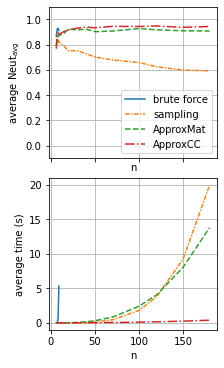

In [30]:
fig, axes = plt.subplots(2, 1, figsize=(3,5), sharex=True, constrained_layout=True)
# fig.suptitle('PathMaxTSP solver performances')

axes[0].plot(n_domain, neuts, label=solver_names)
# axes[0].plot(n_domain, [1 for _ in n_domain], label='upper bound', color='black', linestyle=':')
axes[0].set_xlabel('n')
axes[0].set_ylabel(r'average $\operatorname{Neut}_{\operatorname{avg}}$')
axes[0].set_ybound(-0.1, 1.1)

# axes[0].set_xscale('log')

axes[1].plot(n_domain, times)
axes[1].set_xlabel('n')
axes[1].set_ylabel('average time (s)')

# axes[1].set_xscale('log')
# axes[1].set_yscale('log')

axes[0].grid(visible=True)
axes[1].grid(visible=True)
axes[0].legend(loc="lower right")

plt.savefig(f"plots/avg_agg_plots_{dist_name}_{do_adjust_weights_str}.pdf")

### min aggregation

In [31]:
solvers_ma = [
    via_brute_force_min_agg,
    via_sampling_min_agg,
    min_agg
]

solver_names_ma = [
    "brute force",
    "sampling",
    "heuristic method"
]

assert len(solvers) == len(solver_names)

In [32]:
n = 9
G = init_graph(n, do_adjust_weights)

for func, name in zip(solvers_ma, solver_names_ma):
    print(f"solver: {name}")
    start = perf_counter()
    p = func(G, n, verbose=True)
    t = perf_counter() - start
    neut = neutrality(G, p, min)
    print(f"Neut_min: {neut}\ntime (s): {t}\n")

solver: brute force
Neut_min: 0.8612050770481381
time (s): 5.207426399996621

solver: sampling
Neut_min: 0.7084137717913365
time (s): 0.009884200000669807

solver: heuristic method
%%% average iterations till convergence: 3.1666666666666665 %%%
Neut_min: 0.8090185537630808
time (s): 0.015101800003321841



In [33]:
n_domain_ma = [6, 7, 8, 9, 15, 20, 30, 40, 50, 70]

In [34]:
# iterate over different values of n
neuts_ma = []
times_ma = []
for n in tqdm(n_domain_ma):
    Gs = [init_graph(n, do_adjust_weights) for i in range(iterations)]
    
    # iterate over the different solvers
    inner_neuts = []
    inner_times = []
    for func in solvers_ma:
        if n > 10 and func == via_brute_force_min_agg:
            inner_neuts.append(None)
            inner_times.append(None)
            continue
        
        # iterate over the different random graphs
        inner_inner_neuts = []
        inner_inner_times = []
        for i in range(iterations):
            # take the best of `timeit_iterations` times to account for external performance factors
            time_min = math.inf
            for j in range(timeit_iterations):
                start = perf_counter()
                p = func(Gs[i], n)
                t = perf_counter() - start
                time_min = min(time_min, t)
            inner_inner_neuts.append(neutrality(Gs[i], p, min))
            inner_inner_times.append(time_min)
        inner_neuts.append(avg(inner_inner_neuts))
        inner_times.append(avg(inner_inner_times))
    neuts_ma.append(inner_neuts)
    times_ma.append(inner_times)

100%|███████████████████████████████████████████████████████████████| 10/10 [11:05<00:00, 66.51s/it]


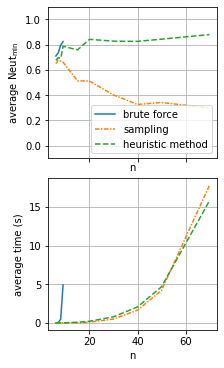

In [35]:
fig, axes = plt.subplots(2, 1, figsize=(3,5), sharex=True, constrained_layout=True)
# fig.suptitle('PathMaxScatterTSP solver performances')

axes[0].plot(n_domain_ma, neuts_ma, label=solver_names_ma)
# axes[0].plot(n_domain_ma, [1 for _ in n_domain_ma], label='upper bound', color='black', linestyle=':')
axes[0].set_xlabel('n')
axes[0].set_ylabel(r'average $\operatorname{Neut}_{\min}$')
axes[0].set_ybound(-0.1, 1.1)

# axes[0].set_xscale('log')

axes[1].plot(n_domain_ma, times_ma)
axes[1].set_xlabel('n')
axes[1].set_ylabel('average time (s)')

# axes[1].set_xscale('log')
# axes[1].set_yscale('log')

axes[0].legend(loc="lower right")
axes[0].grid(visible=True)
axes[1].grid(visible=True)

plt.savefig(f"plots/min_agg_plots_{dist_name}_{do_adjust_weights_str}.pdf")

#### early stopping

In [36]:
n = 60
lim_domain = range(1,7)

In [37]:
Gs = [init_graph(n, do_adjust_weights) for i in range(iterations)]

# iterate over different values of lim
neuts_es = []
times_es = []
for lim in tqdm(lim_domain):
    # iterate over the different random graphs
    inner_inner_neuts = []
    inner_inner_times = []
    for i in range(iterations):
        # take the best of `timeit_iterations` times to account for external performance factors
        time_min = math.inf
        for j in range(timeit_iterations):
            start = perf_counter()
            p = min_agg(Gs[i], n, lim=lim)
            t = perf_counter() - start
            time_min = min(time_min, t)
        inner_inner_neuts.append(neutrality(Gs[i], p, min))
        inner_inner_times.append(time_min)
    neuts_es.append(avg(inner_inner_neuts))
    times_es.append(avg(inner_inner_times))

100%|█████████████████████████████████████████████████████████████████| 6/6 [07:46<00:00, 77.78s/it]


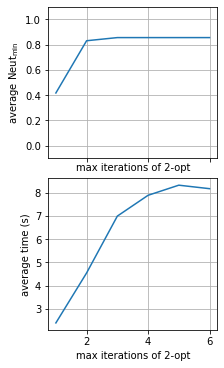

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(3,5), sharex=True, constrained_layout=True)
# fig.suptitle('min aggregation early stopping')

axes[0].plot(lim_domain, neuts_es, label="heuristic method")
# axes[0].plot(lim_domain, [1 for _ in lim_domain], label='upper bound', color='black', linestyle=':')
axes[0].set_xlabel('max iterations of 2-opt')
axes[0].set_ylabel(r'average $\operatorname{Neut}_{\min}$')
axes[0].set_ybound(-0.1, 1.1)

axes[1].plot(lim_domain, times_es)
axes[1].set_xlabel('max iterations of 2-opt')
axes[1].set_ylabel('average time (s)')

# axes[0].legend(loc="lower right")
axes[0].grid(visible=True)
axes[1].grid(visible=True)

plt.savefig(f"plots/early_stopping_{dist_name}_{do_adjust_weights_str}.pdf")

### real data

In [ ]:
import os

In [ ]:
Gs = {}
with os.scandir("data/Jul/graphs") as directory:
    for entry in directory:
        if entry.is_file():
            print(f"reading {entry.name}...")
            source_id = entry.name[0]
            Gs[source_id] = nx.read_weighted_edgelist(entry.path, nodetype=int)

In [ ]:
for s, G in Gs.items():
    print(f"SOURCE {s}")
    n = len(G.nodes)
    for func, name in zip(solvers_ma, solver_names_ma):
        print(f"solver: {name}")
        start = perf_counter()
        p = func(G, n, verbose=True)
        t = perf_counter() - start
        neut = neutrality(G, p, min)
        print(f"Neut_min: {neut}\ntime (s): {t}\n")